In [1]:
using Revise
using MGVInference

using Distributions
using Random
using ValueShapes
using LinearAlgebra
using Optim

In [3]:
include("../test/test_models/model_polyfit.jl");

In [4]:
starting_point

5-element Array{Float64,1}:
  0.2
  0.5
 -0.1
  0.3
 -0.6

In [5]:
function pprintln(obj)
    show(stdout, "text/plain", obj)
    println()
end

pprintln (generic function with 1 method)

In [6]:
using Plots
gr(size=(400, 300), dpi=700)

Plots.GRBackend()

In [7]:
rng = MersenneTwister(157);

In [8]:
data = rand(rng, model(true_params), 1)[1];

In [9]:
function _mean(x::Vector)
    _mean(_common_grid, x)
end

_mean (generic function with 2 methods)

In [10]:
init_plots =() -> let
    truth = _mean(true_params)
    plot!(_common_grid, truth, markercolor=:blue, linecolor=:blue, label="truth")
    scatter!(_common_grid, _mean(starting_point), markercolor=:orange, markerstrokewidth=0, markersize=3, label="init")
    scatter!(vcat(_x1_grid, _x2_grid), MGVInference.unshaped(data), markercolor=:black, markerstrokewidth=0, markersize=3, label="data")
end

#9 (generic function with 1 method)

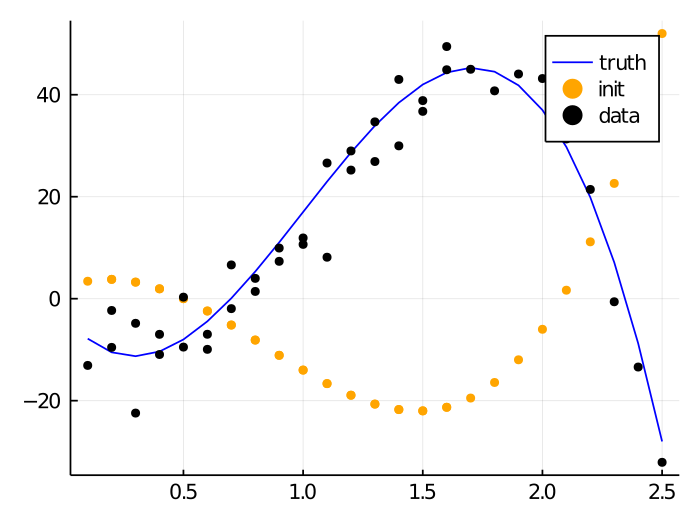

In [11]:
plot()
init_plots()

In [ ]:
first_iteration = mgvi_kl_optimize_step(rng,
                                        model, data,
                                        starting_point;
                                        num_residuals=3,
                                        jacobian_func=FwdRevADJacobianFunc,
                                        residual_sampler=ImplicitResidualSampler,
                                        optim_options=Optim.Options(iterations=10, show_trace=true),
                                        residual_sampler_options=(;cg_params=(;verbose=true)),
                                        )
pprintln(hcat(first_iteration.result, true_params))

In [ ]:
plot_iteration = (params, label) -> let
    ##error_mat = mgvi_kl_errors(full_model, params)
    ##display(error_mat)
    ##errors = sqrt.(error_mat[diagind(error_mat)])
    ##yerr = abs.(line(common_grid, params+errors) - line(common_grid, params-errors))
    ##scatter!(common_grid, line(common_grid, params), markercolor=:green, label=label, yerr=yerr)
    for sample in eachcol(params.samples)
        scatter!(_common_grid, _mean(Vector(sample)), markercolor=:gray, markeralpha=0.3, markersize=2, label=nothing)
    end
    scatter!(_common_grid, _mean(params.result), markercolor=:green, label=label)
end

In [ ]:
plot()
init_plots()
plot_iteration(first_iteration, "first")

In [ ]:
plot_iteration_light = (params, counter) -> let
    scatter!(_common_grid, _mean(params.result), markercolor=:green, markersize=3, markeralpha=2*atan(counter/18)/π, label=nothing)
end

In [ ]:
next_iteration = first_iteration
for i in 1:3
    #pprintln(minimum(next_iteration.optimized))
    pprintln(hcat(next_iteration.result, true_params))
    new_iteration = mgvi_kl_optimize_step(rng,
                                                  model, data,
                                                  next_iteration.result;
                                                  num_residuals=3,
                                                  jacobian_func=FwdRevADJacobianFunc,
                                                  residual_sampler=ImplicitResidualSampler,
                                                  optim_options=Optim.Options(iterations=10, show_trace=true),
                                                  residual_sampler_options=(;cg_params=(;verbose=true)))

    global next_iteration = new_iteration
end
#pprintln(minimum(next_iteration.optimized))
pprintln(hcat(next_iteration.result, true_params))

In [ ]:
plot()
init_plots()
plot_iteration(next_iteration, "last")